In [10]:
import yfinance as yf
import pandas as pd

In [11]:
snp = yf.Ticker("^GSPC")
snp = snp.history(period = "max")

In [59]:
snp.index = pd.to_datetime(snp.index)

In [60]:
snp.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-11-15 00:00:00-05:00', '2023-11-16 00:00:00-05:00',
               '2023-11-17 00:00:00-05:00', '2023-11-20 00:00:00-05:00',
               '2023-11-21 00:00:00-05:00', '2023-11-22 00:00:00-05:00',
               '2023-11-24 00:00:00-05:00', '2023-11-27 00:00:00-05:00',
               '2023-11-28 00:00:00-05:00', '2023-11-29 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24094, freq=None)

<Axes: xlabel='Date'>

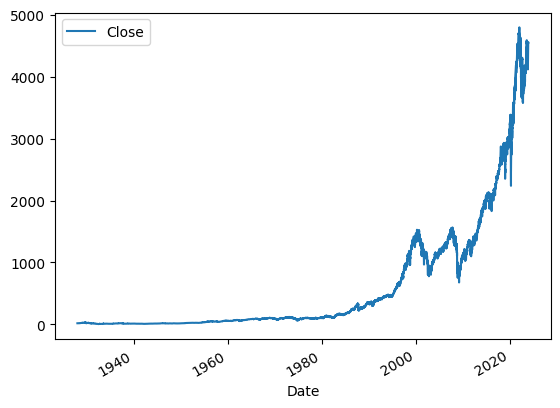

In [61]:
snp.plot.line(y="Close", use_index = True)

In [ ]:
snp.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)

In [63]:
snp["Tomorrow"] = snp["Close"].shift(-1)
snp["Target"] = (snp["Tomorrow"]>snp["Close"]).astype(int)
snpR = snp.loc["1990-01-01":].copy()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-11-22 00:00:00-05:00,4553.040039,4568.430176,4545.049805,4556.620117,3042810000,4559.339844,1
2023-11-24 00:00:00-05:00,4555.839844,4560.310059,4552.799805,4559.339844,1639500000,4550.430176,0
2023-11-27 00:00:00-05:00,4554.859863,4560.520020,4546.319824,4550.430176,3403990000,4554.890137,1


In [88]:
horizons = [2,5,60,250,1000]
new_predictors = []
for horizon in horizons:
    rolling_averages = snpR.rolling(horizon).mean()

    ratio_column = "Close Ratio_", horizon
    snpR[ratio_column] = snpR["Close"] / rolling_averages["Close"]

    trend_column = "Trend_", horizon
    snpR[trend_column] = snpR.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column] 

In [67]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100,
                               random_state = 101, n_jobs=-1)
train = snpR.iloc[:-100]
test = snpR.iloc[-100:]

predictors = ["Open", "High", "Low", "Close", "Volume"]

In [68]:
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_jobs=-1, random_state=101)

In [69]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [70]:
precision_score(test["Target"], preds)

0.5138888888888888

<Axes: xlabel='Date'>

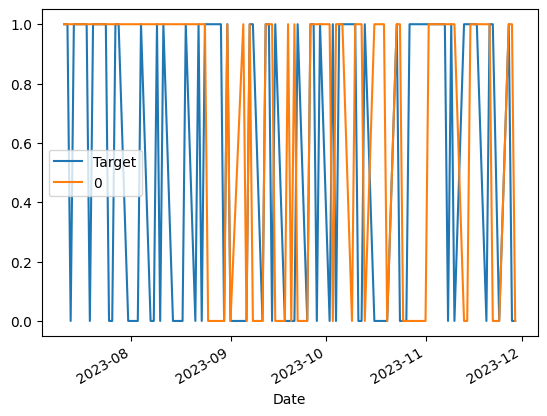

In [71]:
combined = pd.concat([test["Target"],preds], axis=1)
combined.plot()

In [73]:
def backprop(data, model, predictors, start = 2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [119]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds = (preds>=0.6).astype(int)
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"],preds], axis=1)
    return combined

In [120]:
predictions = backprop(snpR, model, predictors)

In [121]:
predictions["Predictions"].value_counts()

Predictions
0    4753
1     290
Name: count, dtype: int64

In [122]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5827586206896552

In [123]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.543724
0    0.456276
Name: count, dtype: float64

In [124]:
snpR.dropna(inplace=True)

In [125]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=101, n_jobs=-1)

In [126]:
predictions = backprop(snpR, model, new_predictors)

In [127]:
predictions["Predictions"].value_counts()

Predictions
0    5027
1      16
Name: count, dtype: int64

In [128]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5625